## Cellular Automata
### Cel
Zamodelować model epidemii przy pomocy automatu komórkowego.
### Realizacja
Nasz model realizuje:
* prawdopodobieństwo zakażenia się, wyzdrowienia lub śmierci zależne od wieku osoby
* możliwość wynalezienia szczepionki i zaszczepienia się
* możliwość wyboru startu rozsprzestrzeniania się epidemii
* ustalanie parametrów:
    * łatwości rozsprzestrzeniania
    * śmiertelności
    * trudności wyzdrowienia
    * oporu do zaszczepienia się
    * szybkości opracowania szczepionki

Zacznijmy od postawowy działania epidemii, czyli jej rozprzestrzeniania.

In [1]:
using StatsBase
using Plots
using Random, Distributions

HEALTHY, CONVALESCENT, VACCINATED, SICK, DEAD = 0, 1, 2, 3, 4

function get_infected(matrix, i, j, t, infection_likelihood, curr_state)
    nx, ny = size(matrix, 1), size(matrix, 2)
    neighbours = []
    
    for a in -1:1
        for b in -1:1
            x, y = i + a, j + b
            if 0 <= x <= nx && 0 <= y <= ny && !(a == b == 0)
                append!(neighbours, [x, y])
            end
        end
    end
    
    for k in 1:2:size(neighbours, 1)
        x, y = neighbours[k], neighbours[k + 1]
        if matrix[x, y, t] == SICK && matrix[i, j, t + 1] == curr_state
            matrix[i, j, t + 1] = sample([curr_state, SICK], Weights([1 - infection_likelihood, infection_likelihood]))
        end
    end
end

get_infected (generic function with 1 method)

Jako osoba w naszym modelu nie mamy zbyt dużo do roboty: możemy umrzeć (smutna_żaba.jpg), wyzdrowieć lub zaszczepić się.

In [2]:
function die(matrix, i, j, t, death_likelihood)
    matrix[i, j, t + 1] = sample([SICK, DEAD], Weights([1 - death_likelihood, death_likelihood]))
end

function recover(matrix, i, j, t, recovery_likelihood)
    matrix[i, j, t + 1] = sample([SICK, CONVALESCENT], Weights([1 - recovery_likelihood, recovery_likelihood]))
    if matrix[i, j, t + 1] == CONVALESCENT
        return true
    end
    return false
end

function vaccinate(matrix, i, j, t, vaccination_likelihood, curr_state)
    matrix[i, j, t + 1] = sample([curr_state, VACCINATED], Weights([1 - vaccination_likelihood, vaccination_likelihood]))
    if matrix[i, j, t + 1] == VACCINATED
        return true
    end
    return false
end

vaccinate (generic function with 1 method)

Zaszczepieni oraz ozdrowieńcy charakteryzują się mniejszą szansą na zarażenie się i śmierć w trakcie choroby.

In [3]:
function vaccine_effect(infection_prob, death_prob, i, j)
    infection_prob[i][j] /= 50
    death_prob[i][j] /= 100
end

function recovery_effect(infection_prob, death_prob, i, j)
    infection_prob[i][j] /= 10
    death_prob[i][j] /= 25
end

recovery_effect (generic function with 1 method)

Losujemy, czy szczepionka została już wynaleziona.

In [4]:
function invent_vaccine(t, max_t, vaccine_invention)
    invented = sample([true, false], Weights([vaccine_invention * t / max_t, 1 - t / max_t]))
    return invented
end

invent_vaccine (generic function with 1 method)

Generujemy pseudo-normalny rozkład wieku.

In [5]:
function generate_age_dist(nx, ny)
    distribution = Truncated(Normal(0.5, 1), 0, 1)
    matrix = rand(distribution, nx, ny)
    matrix[:,:] *= 100
    for i in 1:nx
        for j in 1:ny
            matrix[i, j] = max(1, round(Int, matrix[i, j]))
        end
    end
    return matrix
end

generate_age_dist (generic function with 1 method)

Wyznaczamy różne potrzebne nam prawdopodobieństwa.

In [6]:
function get_infection_prob(age_distribution, spread)
    nx, ny = size(age_distribution, 1), size(age_distribution, 2)
    matrix = [[(age_distribution[j, i] / 100) ^ 2 *  0.5 * spread for i in 1:ny] for j in 1:nx]
    return matrix
end

function get_death_prob(age_distribution, fatality)
    nx, ny = size(age_distribution, 1), size(age_distribution, 2)
    matrix = [[((age_distribution[j, i] / 100) ^ 3) * 0.3 * fatality for i in 1:ny] for j in 1:nx]
    return matrix
end

function get_recovery_prob(age_distribution, cure_difficulty)
    nx, ny = size(age_distribution, 1), size(age_distribution, 2)
    matrix = [[((age_distribution[j, i] / 100) ^ 2) / cure_difficulty for i in 1:ny] for j in 1:nx]
    return matrix
end

function get_vaccination_prob(age_distribution, vaccination_aversion)
    nx, ny = size(age_distribution, 1), size(age_distribution, 2)
    matrix = [[((age_distribution[j, i] / 100) ^ 3) / vaccination_aversion for i in 1:ny] for j in 1:nx]
    return matrix
end

get_vaccination_prob (generic function with 1 method)

Dwie metody rozpoczęcia epidemii (całkowity random lub jedno kołowe ognisko).

In [7]:
function random_start(matrix, num)
    nx, ny = size(matrix, 1), size(matrix, 2)
    for i in 1:num
        matrix[rand(1:nx), rand(1:ny), 1] = SICK
    end
end

function circular_start(matrix, num)
    nx, ny = size(matrix, 1), size(matrix, 2)
    radius = min(min(nx, ny) / 10, 10)
    center_x, center_y = rand(20:nx - 20), rand(20:ny - 20)
    for i in 1:num
        matrix[round(Int, rand(-1: 1)*rand()*radius + center_x), round(Int, rand(-1: 1)*rand()*radius + center_y), 1] = SICK
    end
end

circular_start (generic function with 1 method)

Główna funkcja symulacji:
* dla każdej epoki iterujemy po każdym człowieku:
    * zdrowi, ozdrowieńcy i zaszczepieni (jeśli są) mogą zachorować
    * jeśli istnieje szczepionka, to:
        * zdrowi i ozdrowieńcy mogą się zaszczepić
    * osoby chore mają szansę wyzdrowieć lub umrzeć

In [8]:
function simulate(nx, ny, nt, spread, start_method, fatality, cure_difficulty, 
        vaccine_aversion, vaccine_invention)   
    
    matrix = zeros(Int8,nx,ny,nt) 

    age_matrix = generate_age_dist(nx, ny)
    infection_prob = get_infection_prob(age_matrix, spread)
    death_prob = get_death_prob(age_matrix, fatality)
    recovery_prob = get_recovery_prob(age_matrix, cure_difficulty)
    vaccination_prob = get_vaccination_prob(age_matrix, vaccine_aversion)

    start_method(matrix, 20)

    vaccine_invented = false

    for t in 1:nt-1

        if !vaccine_invented
            vaccine_invented = invent_vaccine(t, nt, vaccine_invention)
        end

         for j in 2:ny-1
            for i in 2:nx-1

                matrix[i,j,t+1] = matrix[i,j,t]

                if matrix[i,j,t] == HEALTHY || matrix[i,j,t] == VACCINATED || matrix[i,j,t] == CONVALESCENT
                    if (matrix[i,j,t] == HEALTHY || matrix[i,j,t] == CONVALESCENT) && vaccine_invented
                        vaccinated = vaccinate(matrix, i, j, t, vaccination_prob[i][j], matrix[i,j,t])
                        if !vaccinated
                            get_infected(matrix, i, j, t, infection_prob[i][j], matrix[i,j,t])
                        else
                            vaccine_effect(infection_prob, death_prob, i, j)
                        end
                    else
                        get_infected(matrix, i, j, t, infection_prob[i][j], matrix[i,j,t])
                    end
                end

                if matrix[i,j,t] == SICK
                    has_recovered = recover(matrix, i, j, t, recovery_prob[i][j])
                    if !has_recovered
                        die(matrix, i, j, t, death_prob[i][j])
                    else
                        recovery_effect(infection_prob, death_prob, i, j)
                    end
                end
            end
        end
    end
    return matrix
end


function make_gif(matrix, filename)
    epoques = size(matrix, 3)
    result = @animate for t ∈ 1:epoques
        heatmap(matrix[:,:,t], clims=(0, 4), color=cgrad([:green,:lightgreen, :blue, :orange, :red]))
    end
    gif(result, filename, fps=15)
end

make_gif (generic function with 1 method)

In [9]:
function count_people(matrix, t, person_type)
    nx, ny = size(matrix, 1), size(matrix, 2)
    res = 0
    for i in 1:nx
        for j in 1:ny
            if matrix[i, j, t] == person_type
                res += 1
            end
        end
    end
    return res
end

function plot_results(matrix)
    args = [1:EPOQUES]

    healthy = [count_people(matrix, q, HEALTHY) for q in 1:EPOQUES]
    convalescent = [count_people(matrix, q, CONVALESCENT) for q in 1:EPOQUES]
    vaccinated = [count_people(matrix, q, VACCINATED) for q in 1:EPOQUES]
    sick = [count_people(matrix, q, SICK) for q in 1:EPOQUES]
    dead = [count_people(matrix, q, DEAD) for q in 1:EPOQUES]

    plot(args, [healthy, convalescent, vaccinated, sick, dead], label=["Healthy" "Convalescent" "Vaccinated" "Sick" "Dead"],
    linewidth=3, ylabel="Number of people", xlabel="Day")
end

plot_results (generic function with 1 method)

Najbardziej typowa sytuacja:
* łatwo rozsprzestrzeniająca się choroba
* średnia śmiertelność
* szczepionek zbyt mało i zbyt późno, by powstrzymać epidemię

┌ Info: Saved animation to 
│   fn = C:\Users\sigor\PycharmProjects\MOWNiT\lab5\std.gif
└ @ Plots C:\Users\sigor\.julia\packages\Plots\cPJQu\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sigor\\PycharmProjects\\MOWNiT\\lab5\\std.gif")
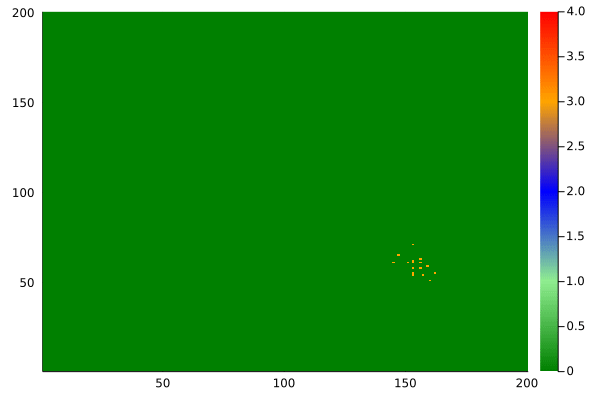

In [10]:
WIDTH, HEIGHT, EPOQUES = 200, 200, 100
SPREAD, START_METHOD = 5, circular_start
FATALITY =  1
CURE_DIFFICULTY = 10
VACCINE_AVERSION = 50
FASTER_VACCINE_INVENTION = 0.5
FILENAME = "std.gif"

matrix = simulate(WIDTH, HEIGHT, EPOQUES, SPREAD, START_METHOD, FATALITY,
    CURE_DIFFICULTY, VACCINE_AVERSION, FASTER_VACCINE_INVENTION)

make_gif(matrix, FILENAME)

<div style="display:flex">
    <div style="width:100px">
        <div style="background-color:red; width:100px; height:50px"></div>
        <div style="position:center">Dead</div>
    </div style="width:100px">
    <div style="width:100px">
        <div style="background-color:orange; width:100px; height:50px"></div>
        <div style="position:center">Sick</div>
    </div>
    <div style="width:100px">
        <div style="background-color:blue; width:100px; height:50px"></div>
        <div style="position:center">Vaccinated</div>
    </div>
    <div style="width:100px">
        <div style="background-color:#90EE90; width:100px; height:50px"></div>
        <div style="position:center">Convalescent</div>
    </div>
    <div style="width:100px">
        <div style="background-color:green; width:100px; height:50px"></div>
        <div style="position:center">Healthy</div>
    </div>
</div>

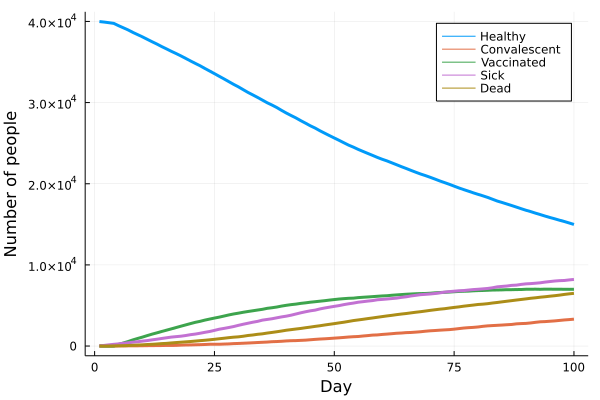

In [11]:
plot_results(matrix)

Wariant:
* średnio zaraźliwa choroba o dużej śmiertelności
* wysoka chęć do zaszczepienia się
* szybkość opracowania szczepionki
* efekt: mocne zachamowanie dalszych zarażeń

┌ Info: Saved animation to 
│   fn = C:\Users\sigor\PycharmProjects\MOWNiT\lab5\vaccines.gif
└ @ Plots C:\Users\sigor\.julia\packages\Plots\cPJQu\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sigor\\PycharmProjects\\MOWNiT\\lab5\\vaccines.gif")
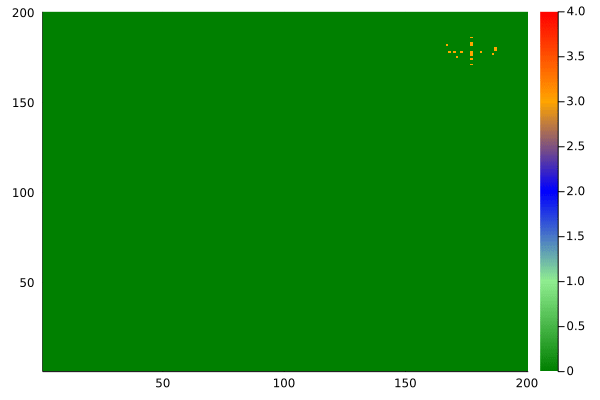

In [12]:
WIDTH, HEIGHT, EPOQUES = 200, 200, 120
SPREAD, START_METHOD = 2, circular_start
FATALITY =  5
CURE_DIFFICULTY = 15
VACCINE_AVERSION = 45
FASTER_VACCINE_INVENTION = 1
FILENAME = "vaccines.gif"

matrix = simulate(WIDTH, HEIGHT, EPOQUES, SPREAD, START_METHOD, FATALITY,
    CURE_DIFFICULTY, VACCINE_AVERSION, FASTER_VACCINE_INVENTION)

make_gif(matrix, FILENAME)

<div style="display:flex">
    <div style="width:100px">
        <div style="background-color:red; width:100px; height:50px"></div>
        <div style="position:center">Dead</div>
    </div style="width:100px">
    <div style="width:100px">
        <div style="background-color:orange; width:100px; height:50px"></div>
        <div style="position:center">Sick</div>
    </div>
    <div style="width:100px">
        <div style="background-color:blue; width:100px; height:50px"></div>
        <div style="position:center">Vaccinated</div>
    </div>
    <div style="width:100px">
        <div style="background-color:#90EE90; width:100px; height:50px"></div>
        <div style="position:center">Convalescent</div>
    </div>
    <div style="width:100px">
        <div style="background-color:green; width:100px; height:50px"></div>
        <div style="position:center">Healthy</div>
    </div>
</div>

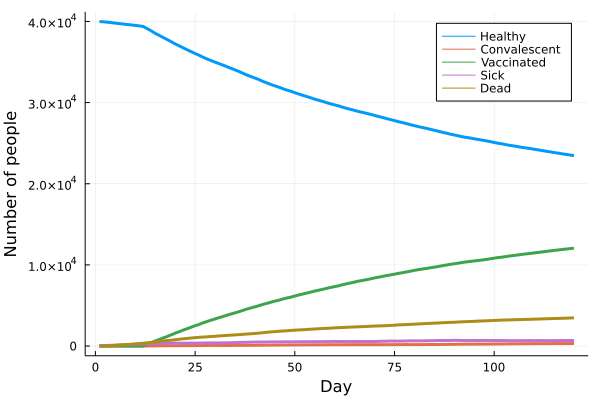

In [13]:
plot_results(matrix)

Wariant:
* choroba tak zabójcza, że sama się eradykowała

┌ Info: Saved animation to 
│   fn = C:\Users\sigor\PycharmProjects\MOWNiT\lab5\too_deadly.gif
└ @ Plots C:\Users\sigor\.julia\packages\Plots\cPJQu\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sigor\\PycharmProjects\\MOWNiT\\lab5\\too_deadly.gif")
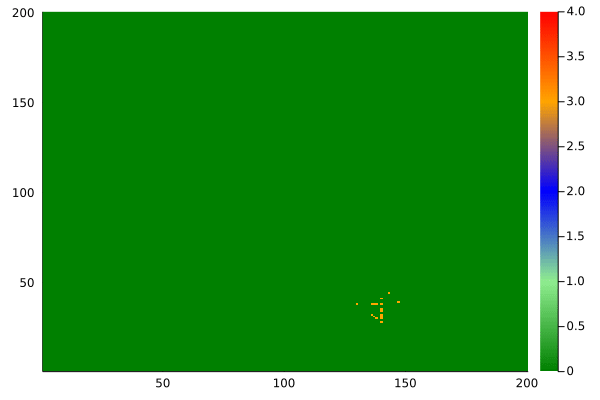

In [14]:
WIDTH, HEIGHT, EPOQUES = 200, 200, 60
SPREAD, START_METHOD = 1.5, circular_start
FATALITY =  50
CURE_DIFFICULTY = 15
VACCINE_AVERSION = 150
FASTER_VACCINE_INVENTION = 0.1
FILENAME = "too_deadly.gif"

matrix = simulate(WIDTH, HEIGHT, EPOQUES, SPREAD, START_METHOD, FATALITY,
    CURE_DIFFICULTY, VACCINE_AVERSION, FASTER_VACCINE_INVENTION)

make_gif(matrix, FILENAME)

<div style="display:flex">
    <div style="width:100px">
        <div style="background-color:red; width:100px; height:50px"></div>
        <div style="position:center">Dead</div>
    </div style="width:100px">
    <div style="width:100px">
        <div style="background-color:orange; width:100px; height:50px"></div>
        <div style="position:center">Sick</div>
    </div>
    <div style="width:100px">
        <div style="background-color:blue; width:100px; height:50px"></div>
        <div style="position:center">Vaccinated</div>
    </div>
    <div style="width:100px">
        <div style="background-color:#90EE90; width:100px; height:50px"></div>
        <div style="position:center">Convalescent</div>
    </div>
    <div style="width:100px">
        <div style="background-color:green; width:100px; height:50px"></div>
        <div style="position:center">Healthy</div>
    </div>
</div>

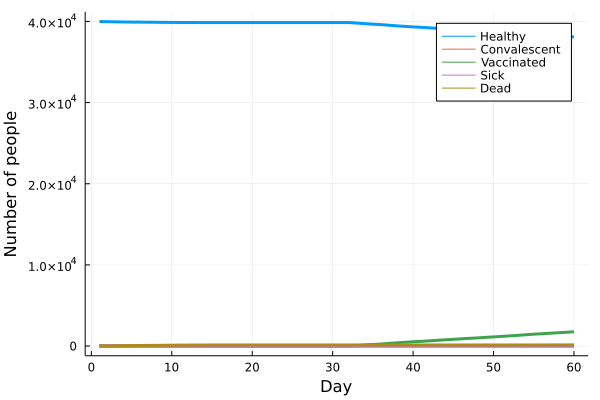

In [15]:
plot_results(matrix)

Wariant:
* szybko rozsprzestrzeniająca się, ale mało zabójcza choroba
* bardzo łatwa do wyleczenia
* średnia chęć szczepionek
* efekt: prawie wszyscy zachorowali, ale wyzdrowieli

┌ Info: Saved animation to 
│   fn = C:\Users\sigor\PycharmProjects\MOWNiT\lab5\easy_to_cure.gif
└ @ Plots C:\Users\sigor\.julia\packages\Plots\cPJQu\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sigor\\PycharmProjects\\MOWNiT\\lab5\\easy_to_cure.gif")
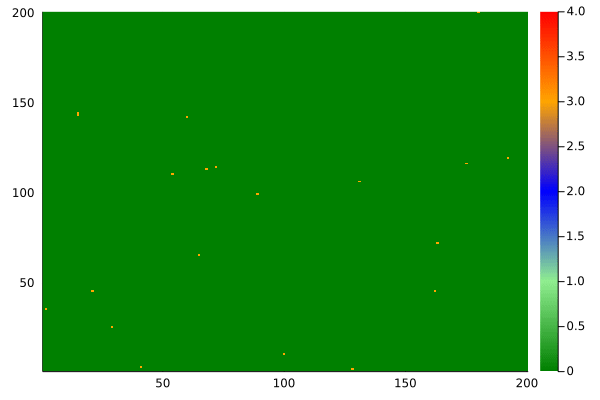

In [16]:
WIDTH, HEIGHT, EPOQUES = 200, 200, 120
SPREAD, START_METHOD = 4, random_start
FATALITY =  2
CURE_DIFFICULTY = 0.5
VACCINE_AVERSION = 80
FASTER_VACCINE_INVENTION = 0.5
FILENAME = "easy_to_cure.gif"

matrix = simulate(WIDTH, HEIGHT, EPOQUES, SPREAD, START_METHOD, FATALITY,
    CURE_DIFFICULTY, VACCINE_AVERSION, FASTER_VACCINE_INVENTION)

make_gif(matrix, FILENAME)

<div style="display:flex">
    <div style="width:100px">
        <div style="background-color:red; width:100px; height:50px"></div>
        <div style="position:center">Dead</div>
    </div style="width:100px">
    <div style="width:100px">
        <div style="background-color:orange; width:100px; height:50px"></div>
        <div style="position:center">Sick</div>
    </div>
    <div style="width:100px">
        <div style="background-color:blue; width:100px; height:50px"></div>
        <div style="position:center">Vaccinated</div>
    </div>
    <div style="width:100px">
        <div style="background-color:#90EE90; width:100px; height:50px"></div>
        <div style="position:center">Convalescent</div>
    </div>
    <div style="width:100px">
        <div style="background-color:green; width:100px; height:50px"></div>
        <div style="position:center">Healthy</div>
    </div>
</div>

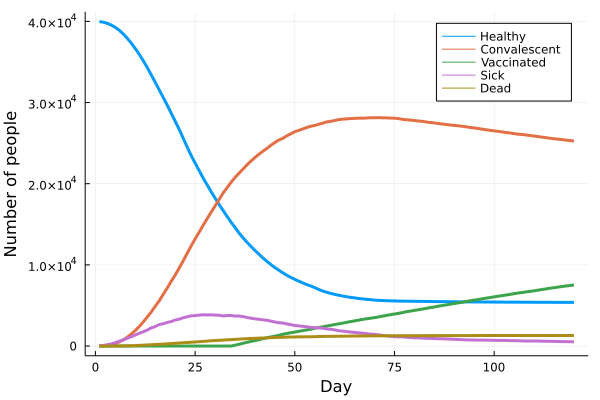

In [17]:
plot_results(matrix)

Wariant:
* pokazanie działania szczepionek dla wielu ognisk

┌ Info: Saved animation to 
│   fn = C:\Users\sigor\PycharmProjects\MOWNiT\lab5\random_vaccines.gif
└ @ Plots C:\Users\sigor\.julia\packages\Plots\cPJQu\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sigor\\PycharmProjects\\MOWNiT\\lab5\\random_vaccines.gif")
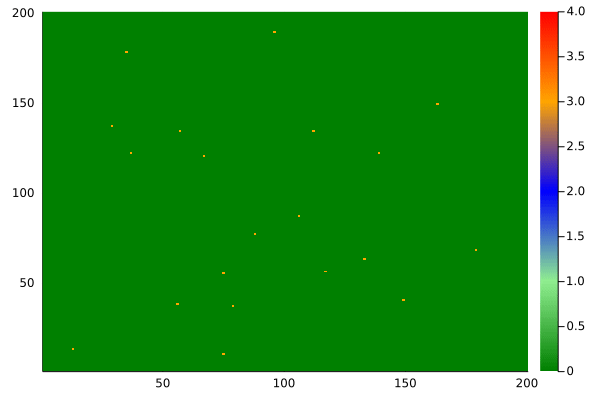

In [18]:
WIDTH, HEIGHT, EPOQUES = 200, 200, 120
SPREAD, START_METHOD = 4, random_start
FATALITY = 1.2
CURE_DIFFICULTY = 1.5
VACCINE_AVERSION = 8
FASTER_VACCINE_INVENTION = 1.7
FILENAME = "random_vaccines.gif"

matrix = simulate(WIDTH, HEIGHT, EPOQUES, SPREAD, START_METHOD, FATALITY,
    CURE_DIFFICULTY, VACCINE_AVERSION, FASTER_VACCINE_INVENTION)

make_gif(matrix, FILENAME)

<div style="display:flex">
    <div style="width:100px">
        <div style="background-color:red; width:100px; height:50px"></div>
        <div style="position:center">Dead</div>
    </div style="width:100px">
    <div style="width:100px">
        <div style="background-color:orange; width:100px; height:50px"></div>
        <div style="position:center">Sick</div>
    </div>
    <div style="width:100px">
        <div style="background-color:blue; width:100px; height:50px"></div>
        <div style="position:center">Vaccinated</div>
    </div>
    <div style="width:100px">
        <div style="background-color:#90EE90; width:100px; height:50px"></div>
        <div style="position:center">Convalescent</div>
    </div>
    <div style="width:100px">
        <div style="background-color:green; width:100px; height:50px"></div>
        <div style="position:center">Healthy</div>
    </div>
</div>

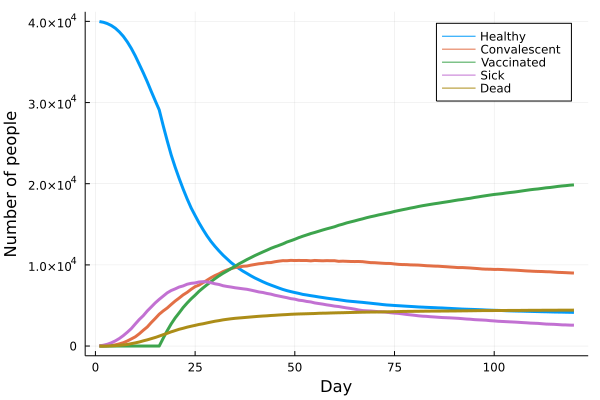

In [19]:
plot_results(matrix)